In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.colors
import matplotlib.pyplot as plt
import time
from sklearn import mixture, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

/home/ag16115/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


### Load Lyon primary school data

In [2]:
fname = 'ia-primary-school-proximity-attr.edges'
file = open(fname)

nodes_i = []
nodes_j = []
hours = []
days = []

node_dict = {}
id_dict = {}
n_idx = 0

for line in file:
    node_i, node_j, t, id_i, id_j = line.strip('\n').split(',')
    
    if node_i not in node_dict:
        node_dict[node_i] = n_idx
        id_dict[node_i] = id_i
        n_idx += 1    

    if node_j not in node_dict:
        node_dict[node_j] = n_idx
        id_dict[node_j] = id_j
        n_idx += 1
        
    nodes_i.append(node_dict[node_i])
    nodes_j.append(node_dict[node_j])
    hours.append(int(int(t)/(60*60)))
    days.append(int(int(t)/(60*60*24)))

Construct the unfolded adjacency matrix $\mathbf{A} = (\mathbf{A}^{(1)} | \cdots | \mathbf{A}^{(T)})$ with $n=242$ nodes and $T=20$ time steps.

In [3]:
n = len(node_dict)
T = 20

As = np.zeros((T,n,n))

for i in range(len(nodes_i)):
    t = 10*int(hours[i]/24) + hours[i]%24 - 8
    As[t, nodes_i[i], nodes_j[i]] = 1
    As[t, nodes_j[i], nodes_i[i]] = 1

Generate plotting colours and markers using the school class for each student, treating teachers as their own separate group.

In [4]:
colours = np.array(list(mpl.colors.TABLEAU_COLORS.keys())[0:6])
colours[5] = 'black'

Z_classes = np.array([{'1A':0, '1B':1, '2A':2, '2B':3, '3A':4, '3B':5, '4A':6, '4B':7, '5A':8, '5B':9, 'Teachers':10}[id_dict[node_id]] for node_id in id_dict])
Z_colours = np.array([colours[{'1':0, '2':1, '3':2, '4':3, '5':4, 'T':5}[id_dict[node_id][0]]] for node_id in id_dict])
Z_markers = np.array([{'A':'o', 'B':'^', 'e':'s'}[id_dict[node_id][1]] for node_id in id_dict])

Create legend key

In [5]:
fig = plt.figure()
handles = [plt.scatter([],[], color='tab:blue', marker='o', s=12, label='Class 1A'),
           plt.scatter([],[], color='tab:blue', marker='^', s=12, label='Class 1B'),
           plt.scatter([],[], color='tab:orange', marker='o', s=12, label='Class 2A'),
           plt.scatter([],[], color='tab:orange', marker='^', s=12, label='Class 2B'),
           plt.scatter([],[], color='tab:green', marker='o', s=12, label='Class 3A'),
           plt.scatter([],[], color='tab:green', marker='^', s=12, label='Class 3B'),
           plt.scatter([],[], color='tab:red', marker='o', s=12, label='Class 4A'),
           plt.scatter([],[], color='tab:red', marker='^', s=12, label='Class 4B'),
           plt.scatter([],[], color='tab:purple', marker='o', s=12, label='Class 5A'),
           plt.scatter([],[], color='tab:purple', marker='^', s=12, label='Class 5B'),
           plt.scatter([],[], color='black', marker='s', s=12, label='Teacher')]
plt.close()

Useful function for more granulated colour maps later.

In [6]:
def categorical_cmap(nc, nsc, cmap='tab10', continuous=False):
    if nc > plt.get_cmap(cmap).N:
        raise ValueError('Too many categories for colormap.')
    if continuous:
        ccolors = plt.get_cmap(cmap)(np.linspace(0,1,nc))
    else:
        ccolors = plt.get_cmap(cmap)(np.arange(nc, dtype=int))
    cols = np.zeros((nc*nsc, 3))
    for i, c in enumerate(ccolors):
        chsv = matplotlib.colors.rgb_to_hsv(c[:3])
        arhsv = np.tile(chsv,nsc).reshape(nsc,3)
        arhsv[:,1] = np.linspace(chsv[1],0.25,nsc)
        arhsv[:,2] = np.linspace(chsv[2],1,nsc)
        rgb = matplotlib.colors.hsv_to_rgb(arhsv)
        cols[i*nsc:(i+1)*nsc,:] = rgb       
    return cols

### Dynamic network spectral embedding

Work out how many dimensions to spectrally embed the unfolded adjacency by looking at the singular values and finding a changepoint using the likelihood profile (Zhu, Ghodsi; 2006).

In [7]:
def dim_select(As, plot=True, plotrange=50):
    # Construct rectangular matrices
    if len(As.shape) == 2:
        As = np.array([As[:,:]])
    
    if len(As.shape) == 3:
        T = len(As)
        A = As[0,:,:]
        for t in range(1,T):
            A = np.block([A,As[t]])
            
    UA, SA, VAt = np.linalg.svd(A)
    
    # Compute likelihood profile
    n = len(SA)
    lq = np.zeros(n); lq[0] = 'nan'
    for q in range(1,n):
        theta_0 = np.mean(SA[:q])
        theta_1 = np.mean(SA[q:])
        sigma = np.sqrt(((q-1)*np.var(SA[:q]) + (n-q-1)*np.var(SA[q:])) / (n-2))
        lq_0 = np.sum(np.log(stats.norm.pdf(SA[:q], theta_0, sigma)))
        lq_1 = np.sum(np.log(stats.norm.pdf(SA[q:], theta_1, sigma)))
        lq[q] = lq_0 +lq_1    
    lq_best = np.nanargmax(lq)

    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(12.0,4.0))
        plt.subplots_adjust(hspace = 0.3)
        
        axs[0].plot(range(plotrange), SA[:plotrange], '.-')
        axs[0].set_title('Singular values')
        axs[0].set_xlabel('Number of dimensions')
        axs[0].axvline(x=lq_best, ls='--', c='k')

        axs[1].plot(range(plotrange), lq[:plotrange], '.-')
        axs[1].set_title('Log likelihood')
        axs[1].set_xlabel('Number of dimensions')
        axs[1].axvline(x=lq_best, ls='--', c='k');
        
    return lq_best

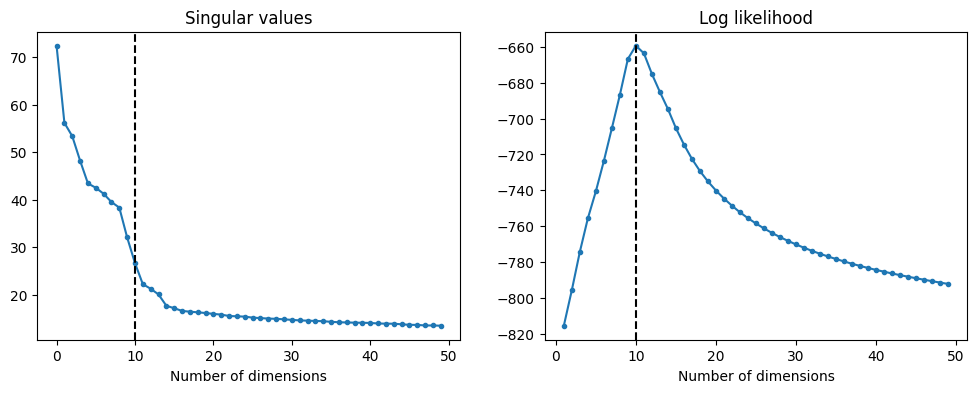

In [8]:
d = dim_select(As)

Create spectral embedding of the unfolded adjacency matrix $\mathbf{A}$ into $d=10$ dimensions. This number makes sense as it matches the number of communities we hope to find in the data; one for each classroom.

In [9]:
def right_embed(As, d):
    # Construct rectangular matrices
    if len(As.shape) == 2:
        As = np.array([As[:,:]])
    
    if len(As.shape) == 3:
        T = len(As)
        A = As[0,:,:]
        for t in range(1,T):
            A = np.block([A,As[t]])
    
    # Spectral embeddings
    UA, SA, VAt = np.linalg.svd(A); VA = VAt.T

    YA = np.zeros((T,n,d))
    for t in range(T):
        YA[t] = VA[t*n:(t+1)*n,0:d].dot(np.diag(np.sqrt(SA[0:d])))
        
    return YA

In [10]:
t0 = time.time()

YA = right_embed(As, d)

t1 = time.time()
print('Execution time:', np.round(t1-t0, 3), 'seconds')

Execution time: 8.168 seconds


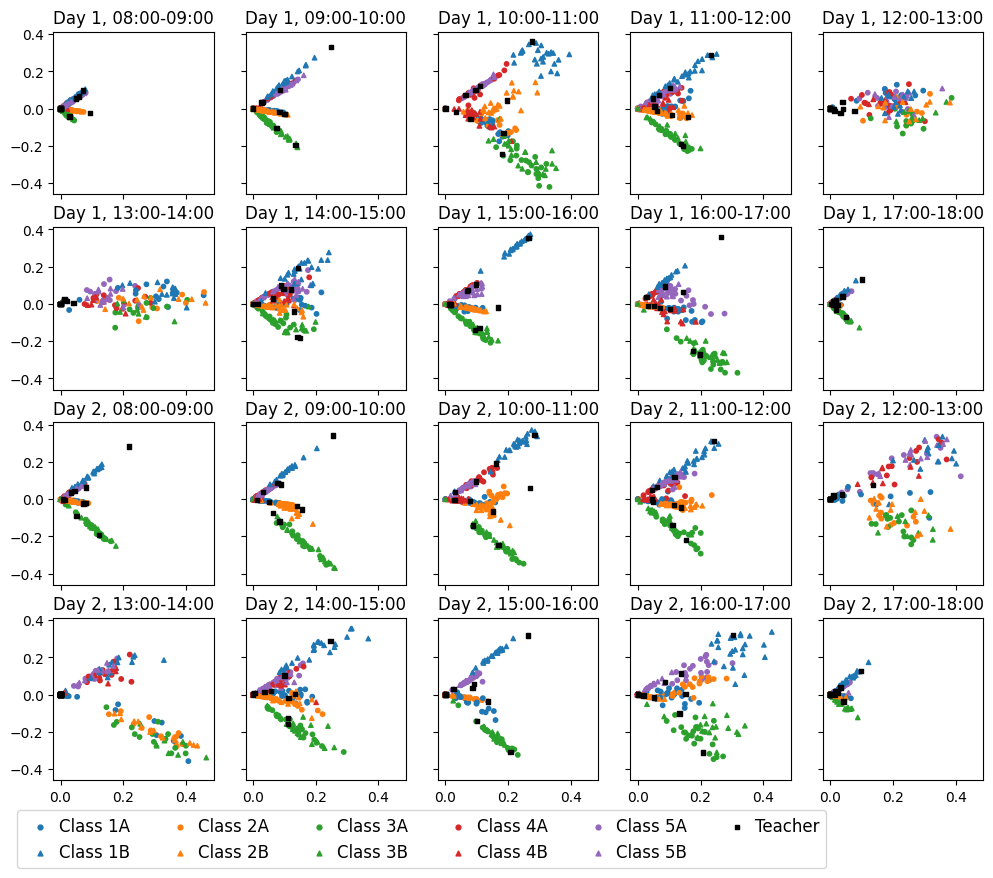

In [11]:
fig, axs = plt.subplots(4, 5, figsize=(12.0,9.6), sharex=True, sharey=True)

for m in ('o','^','s'):
    idx = np.where(Z_markers == m)[0]

    for t in range(T):
        i = int(t/5); j = t%5
        axs[i,j].scatter(YA[t,idx,0], YA[t,idx,1], marker=m, s=10, c=Z_colours[idx])
        
for t in range(T):
    i = int(t/5); j = t%5
    axs[i,j].set_title('Day ' + str(int(t/10)+1) + ', ' + str(t%10+8).zfill(2) + 
                       ':00-' + str(t%10+9).zfill(2) + ':00')

fig.legend(handles=handles, bbox_to_anchor=(0.432,0), loc='lower center', ncol=6, fancybox=True, fontsize=12, handletextpad=0.1)
plt.subplots_adjust(bottom = 0.10);

Spherical coordinates result for degree-corrected SBM (Sanna Passino et al; 2020). We will use this version of the data for all of the following analysis.

In [12]:
def spherical_embed(x):
    d = len(x)
    theta = np.zeros(d-1)
    
    if x[0] > 0:
        theta[0] = np.arccos(x[1] / np.linalg.norm(x[:2]))
    else:
        theta[0] = 2*np.pi - np.arccos(x[1] / np.linalg.norm(x[:2]))
        
    for i in range(d-1):
        theta[i] = np.arccos(x[i+1] / np.linalg.norm(x[:(i+2)]))
        
    return theta

In [13]:
YD = np.zeros((T,n,9))

for t in range(T):
    for i in range(n):
        if np.linalg.norm(YA[t,i]) > 1e-10:
            YD[t,i] = spherical_embed(YA[t,i])

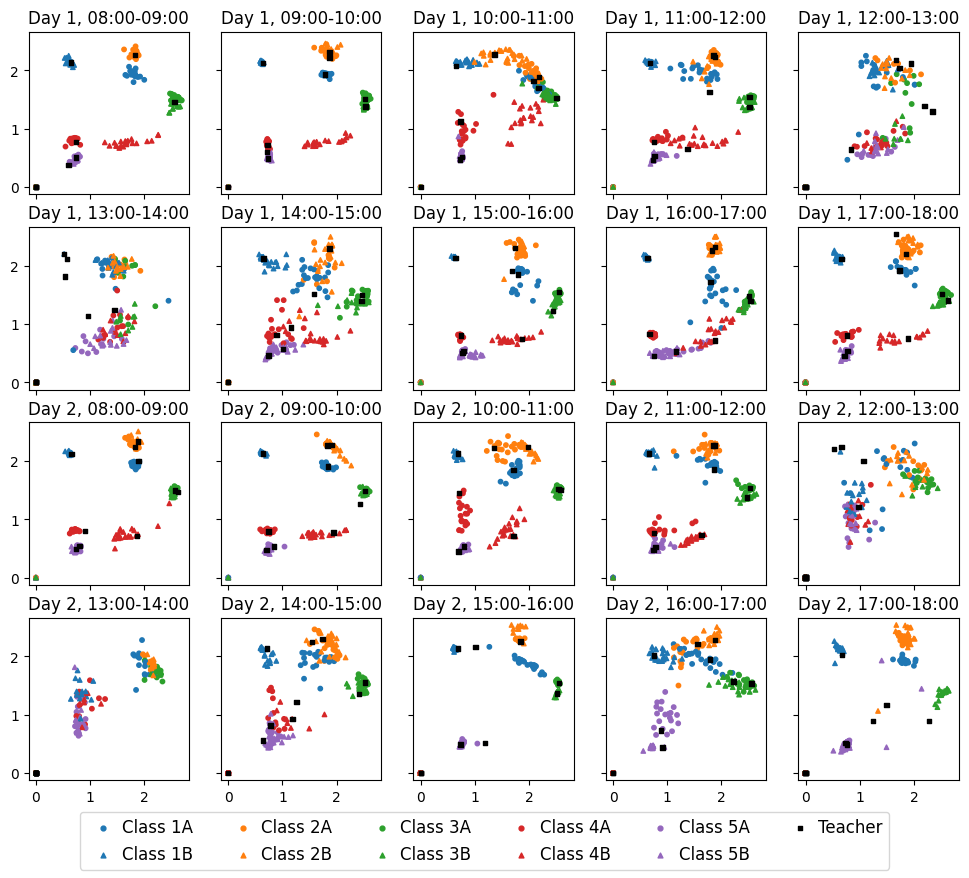

In [14]:
fig, axs = plt.subplots(4, 5, figsize=(12.0,9.6), sharex=True, sharey=True)

for m in ('o','^','s'):
    idx = np.where(Z_markers == m)[0]

    for t in range(T):
        i = int(t/5); j = t%5
        axs[i,j].scatter(YD[t,idx,0], YD[t,idx,1], marker=m, s=10, c=Z_colours[idx])
        
for t in range(T):
    i = int(t/5); j = t%5
    axs[i,j].set_title('Day ' + str(int(t/10)+1) + ', ' + str(t%10+8).zfill(2) + 
                       ':00-' + str(t%10+9).zfill(2) + ':00')

fig.legend(handles=handles, loc='lower center', ncol=6, fancybox=True, fontsize=12, handletextpad=0.1)
plt.subplots_adjust(bottom = 0.10);